# Example 2 - Planar Dipping Layers

This example will show how to convert the geological map below using ``GemGIS`` to a `GemPy` model. This example is based on digitized data. The area is 2932 m wide (W-E extent) and 3677 m high (N-S extent). The model represents several planar stratigraphic units (blue to purple) dipping towards the south above an unspecified basement (light red). The map has been georeferenced with QGIS. The stratigraphic boundaries were digitized in QGIS. Strikes lines were digitized in QGIS as well and will be used to calculate orientations for the `GemPy` model. The contour lines were also digitized and will be interpolated with `GemGIS` to create a topography for the model. 

<img src="../images/cover_example02.png" width="700">

Map Source: An Introduction to Geological Structures and Maps by G.M. Bennison

## Import GemGIS

If you have installed ``GemGIS`` via pip, you can import ``GemGIS`` like any other package. If you have downloaded the repository, append the path to the directory where the ``GemGIS`` repository is stored and then import ``GemGIS``. 

In [1]:
import warnings
warnings.filterwarnings("ignore")
import gemgis as gg

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Importing Libraries and loading Data

All remaining packages can be loaded in order to prepare the data and to construct the model. The example data is downloaded form an external server using `pooch`. It will be stored in a data folder in the same directory where this notebook is stored.  

In [2]:
import geopandas as gpd
import rasterio 

In [3]:
file_path = 'data/example02/'
gg.download_gemgis_data.download_tutorial_data(filename="example02_planar_dipping_layers.zip", dirpath=file_path)

## Creating Digital Elevation Model from Contour Lines

The digital elevation model (DEM) will be created by interpolating contour lines digitized from the georeferenced map using the `SciPy` Radial Basis Function interpolation wrapped in `GemGIS`. The respective function used for that is `gg.vector.interpolate_raster()`. 

<img src="../images/dem_example2.png" width="700">

In [4]:
topo = gpd.read_file(file_path + 'topo2.shp')
topo.head()

,id,Z,geometry
0,None,200,"LINESTRING (66.248 9.085, 187.630 201.563, 284..."
1,None,300,"LINESTRING (2.089 534.498, 109.599 713.104, 22..."
2,None,400,"LINESTRING (5.557 1167.421, 69.716 1294.006, 1..."
3,None,700,"LINESTRING (5.557 2894.521, 59.312 2939.606, 1..."
4,None,600,"LINESTRING (7.291 3267.338, 69.716 3288.147, 1..."


### Interpolating the contour lines

In [5]:
topo_raster = gg.vector.interpolate_raster(gdf=topo, value='Z', method='rbf', res=10)

### Plotting the raster

Text(186.69517142857143, 0.5, 'Y [m]')

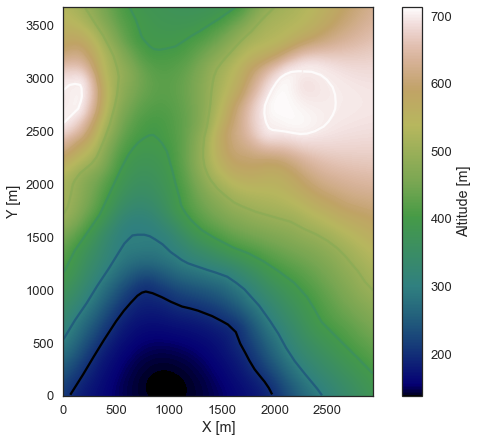

In [6]:
import matplotlib.pyplot as plt

fix, ax = plt.subplots(1)
topo.plot(ax=ax, aspect='equal', column='Z', cmap='gist_earth')
im = plt.imshow(topo_raster, origin='lower', extent=[0,2932,0,3677], cmap='gist_earth')
cbar = plt.colorbar(im)
cbar.set_label('Altitude [m]')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')

### Saving the raster to disc

After the interpolation of the contour lines, the raster is saved to disc using `gg.raster.save_as_tiff()`. The function will not be executed as as raster is already provided with the example data. 

### Opening Raster

The previously computed and saved raster can now be opened using rasterio. 

In [7]:
topo_raster = rasterio.open(file_path + 'raster2.tif')

## Interface Points of stratigraphic boundaries

The interface points will be extracted from LineStrings digitized from the georeferenced map using QGIS. It is important to provide a formation name for each layer boundary. The vertical position of the interface point will be extracted from the digital elevation model using the `GemGIS` function `gg.vector.extract_xyz()`. The resulting GeoDataFrame now contains single points including the information about the respective formation. 

<img src="../images/interfaces_example2.png" width="700">

In [8]:
interfaces = gpd.read_file(file_path + 'interfaces2.shp')
interfaces.head()

,id,formation,geometry
0,None,P,"LINESTRING (1652.891 2.149, 1847.103 185.957, ..."
1,None,Q,"LINESTRING (7.291 898.645, 125.205 810.210, 21..."
2,None,R,"LINESTRING (5.557 2067.386, 121.737 2004.960, ..."
3,None,S,"LINESTRING (4.690 2829.494, 27.232 2837.298, 7..."
4,None,T,"LINESTRING (4.690 3667.901, 133.875 3615.013, ..."


### Extracting Z coordinate from Digital Elevation Model

In [9]:
interfaces_coords = gg.vector.extract_xyz(gdf=interfaces, dem=topo_raster)
interfaces_coords

,formation,geometry,X,Y,Z
0,P,POINT (1652.891 2.149),1652.89,2.15,162.71
1,P,POINT (1847.103 185.957),1847.10,185.96,196.79
2,P,POINT (1994.496 342.020),1994.50,342.02,252.93
3,P,POINT (2121.080 484.211),2121.08,484.21,305.56
4,P,POINT (2235.527 607.327),2235.53,607.33,349.55
...,...,...,...,...,...
121,T,POINT (1476.886 3471.088),1476.89,3471.09,421.32
122,T,POINT (1608.673 3525.710),1608.67,3525.71,436.16
123,T,POINT (1768.204 3591.603),1768.20,3591.60,459.65
124,T,POINT (1903.459 3650.560),1903.46,3650.56,486.01


### Plotting the Interface Points

Text(186.7690025992438, 0.5, 'Y [m]')

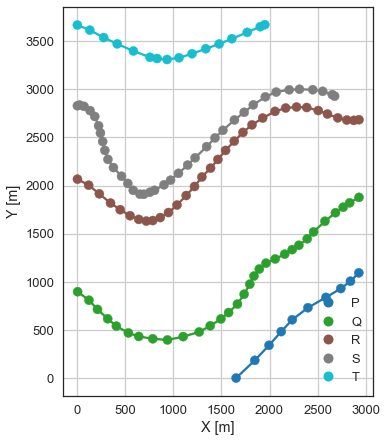

In [10]:
fig, ax = plt.subplots(1)

interfaces.plot(ax=ax, column='formation', legend=True, aspect='equal')
interfaces_coords.plot(ax=ax, column='formation', legend=True, aspect='equal')
plt.grid()
plt.xlabel('X [m]')
plt.ylabel('Y [m]')

## Orientations from Strike Lines

Strike lines connect outcropping stratigraphic boundaries (interfaces) of the same altitude. In other words: the intersections between topographic contours and stratigraphic boundaries at the surface. The height difference and the horizontal difference between two digitized lines is used to calculate the dip and azimuth and hence an orientation that is necessary for `GemPy`. In order to calculate the orientations, each set of strikes lines/LineStrings for one formation must be given an id number next to the altitude of the strike line. The id field is already predefined in QGIS. The strike line with the lowest altitude gets the id number `1`, the strike line with the highest altitude the the number according to the number of digitized strike lines. It is currently recommended to use one set of strike lines for each structural element of one formation as illustrated. 

<img src="../images/orientations_example2.png" width="700">

In [11]:
strikes = gpd.read_file(file_path + 'strikes2.shp')
strikes

,id,formation,Z,geometry
0,1,Q,200,"LINESTRING (399.616 550.104, 1562.287 669.319)"
1,2,Q,300,"LINESTRING (155.551 778.563, 1774.273 938.095)"
2,1,R,400,"LINESTRING (383.576 1797.309, 1101.467 1861.469)"
3,2,R,500,"LINESTRING (99.195 2015.798, 1347.700 2138.915)"
4,1,S,400,"LINESTRING (503.225 2054.380, 1035.140 2108.569)"
5,2,S,500,"LINESTRING (322.018 2272.002, 1329.493 2383.847)"
6,3,S,600,"LINESTRING (249.189 2524.304, 1626.013 2671.697)"
7,4,S,700,"LINESTRING (155.551 2755.798, 2006.634 2942.207)"
8,1,T,400,"LINESTRING (798.965 3326.642, 1129.884 3348.947)"
9,2,T,500,"LINESTRING (296.896 3529.200, 1983.810 3693.066)"


### Calculate Orientations for each formation

In [12]:
orientations_p = gg.vector.calculate_orientations_from_strike_lines(gdf=strikes[strikes['formation']=='P'].sort_values(by='id', ascending=True).reset_index())
orientations_p

,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,23.23,174.96,250.00,POINT (1070.710 247.547),1.00,P,1070.71,247.55
1,22.26,174.67,350.00,POINT (1289.312 511.441),1.00,P,1289.31,511.44
2,21.79,174.41,450.00,POINT (1463.079 780.227),1.00,P,1463.08,780.23


In [13]:
orientations_q = gg.vector.calculate_orientations_from_strike_lines(gdf=strikes[strikes['formation']=='Q'].reset_index())
orientations_q

,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,22.07,174.29,250.00,POINT (972.932 734.020),1.00,Q,972.93,734.02


In [14]:
orientations_r = gg.vector.calculate_orientations_from_strike_lines(gdf=strikes[strikes['formation']=='R'].reset_index())
orientations_r

,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,22.18,174.50,450.00,POINT (732.985 1953.373),1.00,R,732.98,1953.37


In [15]:
orientations_s = gg.vector.calculate_orientations_from_strike_lines(gdf=strikes[strikes['formation']=='S'].reset_index())
orientations_s

,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,22.94,173.78,450.00,POINT (797.469 2204.700),1.00,S,797.47,2204.70
1,21.44,173.81,550.00,POINT (881.678 2462.963),1.00,S,881.68,2462.96
2,23.41,174.12,650.00,POINT (1009.347 2723.501),1.00,S,1009.35,2723.50


In [16]:
orientations_t = gg.vector.calculate_orientations_from_strike_lines(gdf=strikes[strikes['formation']=='T'].reset_index())
orientations_t

,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,21.79,174.52,450.00,POINT (1052.389 3474.464),1.00,T,1052.39,3474.46


### Merging Orientations

In [17]:
import pandas as pd
orientations = pd.concat([orientations_p, orientations_q, orientations_r, orientations_s, orientations_t]).reset_index()
orientations

,index,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,0,23.23,174.96,250.00,POINT (1070.710 247.547),1.00,P,1070.71,247.55
1,1,22.26,174.67,350.00,POINT (1289.312 511.441),1.00,P,1289.31,511.44
2,2,21.79,174.41,450.00,POINT (1463.079 780.227),1.00,P,1463.08,780.23
3,0,22.07,174.29,250.00,POINT (972.932 734.020),1.00,Q,972.93,734.02
4,0,22.18,174.50,450.00,POINT (732.985 1953.373),1.00,R,732.98,1953.37
5,0,22.94,173.78,450.00,POINT (797.469 2204.700),1.00,S,797.47,2204.70
6,1,21.44,173.81,550.00,POINT (881.678 2462.963),1.00,S,881.68,2462.96
7,2,23.41,174.12,650.00,POINT (1009.347 2723.501),1.00,S,1009.35,2723.50
8,0,21.79,174.52,450.00,POINT (1052.389 3474.464),1.00,T,1052.39,3474.46


### Plotting the Orientations

Text(186.7690025992438, 0.5, 'Y [m]')

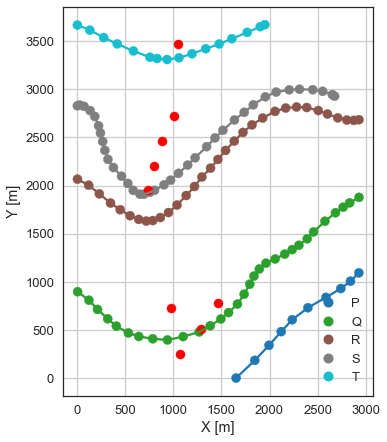

In [18]:
fig, ax = plt.subplots(1)

interfaces.plot(ax=ax, column='formation', legend=True, aspect='equal')
interfaces_coords.plot(ax=ax, column='formation', legend=True, aspect='equal')
orientations.plot(ax=ax, color='red', aspect='equal')
plt.grid()
plt.xlabel('X [m]')
plt.ylabel('Y [m]')

## GemPy Model Construction

The structural geological model will be constructed using the `GemPy` package. 

In [19]:
import gempy as gp

### Creating new Model

In [20]:
geo_model = gp.create_model('Model2')
geo_model

Model2  2021-03-28 14:06

### Initiate Data

In [21]:
gp.init_data(geo_model, [0,2932,0,3677,-700,1000], [100,100,100],
             surface_points_df = interfaces_coords,
             orientations_df = orientations,
             default_values=True)

Active grids: ['regular']


Model2  2021-03-28 14:06

### Model Surfaces

In [22]:
geo_model.surfaces

,surface,series,order_surfaces,color,id
0,P,Default series,1,#015482,1
1,Q,Default series,2,#9f0052,2
2,R,Default series,3,#ffbe00,3
3,S,Default series,4,#728f02,4
4,T,Default series,5,#443988,5


### Mapping the Stack to Surfaces

In [23]:
gp.map_stack_to_surfaces(geo_model,
                         {'Strata': ('P', 'Q', 'R', 'S', 'T')},
                         remove_unused_series=True)
geo_model.add_surfaces('U')

,surface,series,order_surfaces,color,id
0,P,Strata,1,#015482,1
1,Q,Strata,2,#9f0052,2
2,R,Strata,3,#ffbe00,3
3,S,Strata,4,#728f02,4
4,T,Strata,5,#443988,5
5,U,Strata,6,#ff3f20,6


### Showing the Number of Data Points

In [24]:
gg.utils.show_number_of_data_points(geo_model=geo_model)

,surface,series,order_surfaces,color,id,No. of Interfaces,No. of Orientations
0,P,Strata,1,#015482,1,10,3
1,Q,Strata,2,#9f0052,2,31,1
2,R,Strata,3,#ffbe00,3,32,1
3,S,Strata,4,#728f02,4,37,3
4,T,Strata,5,#443988,5,16,1
5,U,Strata,6,#ff3f20,6,0,0


### Loading Digital Elevation Model

In [25]:
geo_model.set_topography(source='gdal', filepath=file_path + 'raster2.tif')

Cropped raster to geo_model.grid.extent.
depending on the size of the raster, this can take a while...
storing converted file...
Active grids: ['regular' 'topography']


Grid Object. Values: 
array([[  14.66      ,   18.385     , -691.5       ],
       [  14.66      ,   18.385     , -674.5       ],
       [  14.66      ,   18.385     , -657.5       ],
       ...,
       [2926.99658703, 3652.02038043,  629.80548096],
       [2926.99658703, 3662.01222826,  629.07196045],
       [2926.99658703, 3672.00407609,  628.35705566]])

### Defining Custom Section

In [26]:
custom_section = gpd.read_file(file_path + 'customsection2.shp')
custom_section_dict = gg.utils.to_section_dict(custom_section, section_column='name')
geo_model.set_section_grid(custom_section_dict)

Active grids: ['regular' 'topography' 'sections']


,start,stop,resolution,dist
Section1,"[974.6659586819704, 3627.5193764495925]","[676.0649712912196, 38.845314576599776]","[100, 80]",3601.08


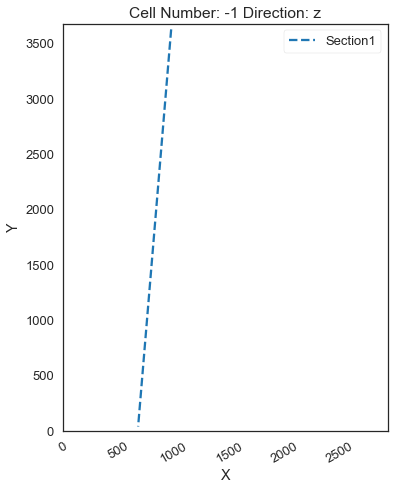

In [27]:
gp.plot.plot_section_traces(geo_model)

### Plotting Input Data

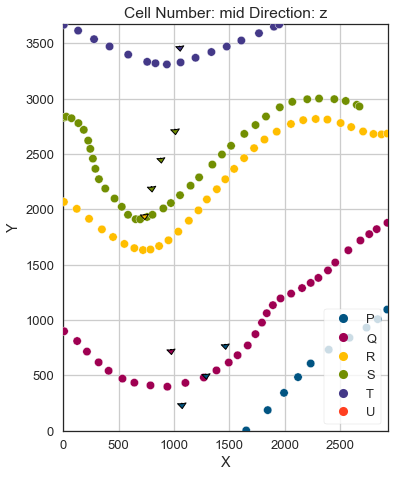

In [28]:
gp.plot_2d(geo_model, direction='z', show_lith=False, show_boundaries=False)
plt.grid()

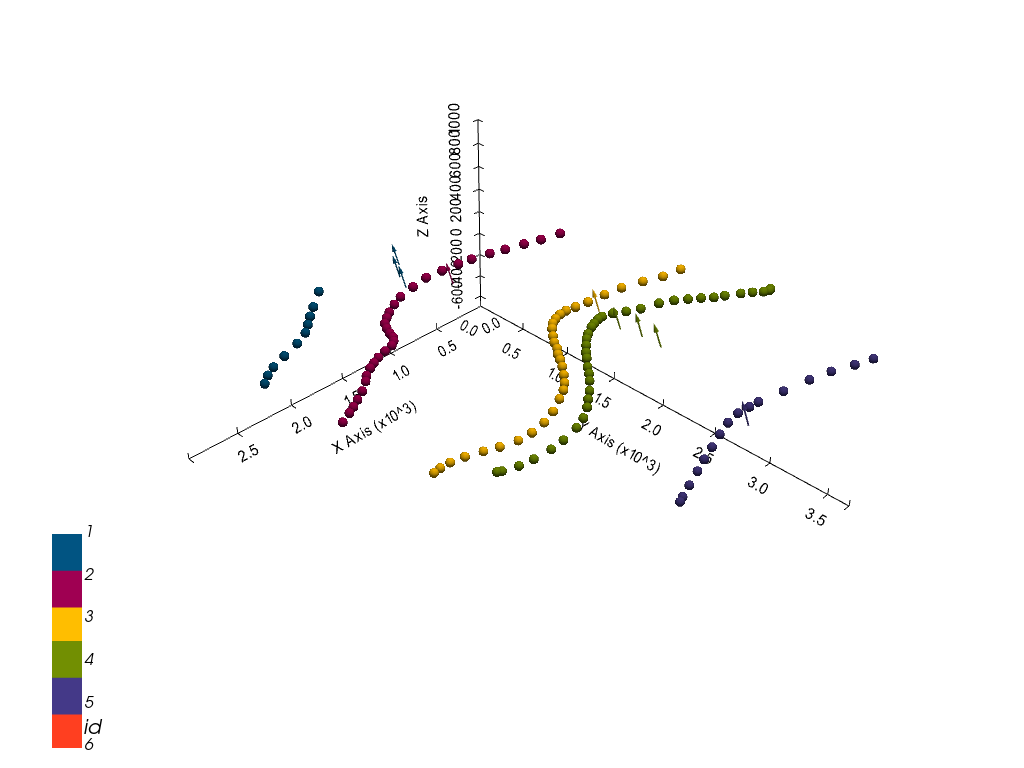

In [29]:
gp.plot_3d(geo_model, image=False, plotter_type='basic', notebook=True)

### Setting the Interpolator

In [30]:
gp.set_interpolator(geo_model,
                    compile_theano=True,
                    theano_optimizer='fast_compile',
                    verbose=[],
                    update_kriging = False
                    )

Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                    values
range              5000.7
$C_o$           595403.64
drift equations       [3]


### Computing Model

In [31]:
sol = gp.compute_model(geo_model, compute_mesh=True)

### Plotting Cross Sections

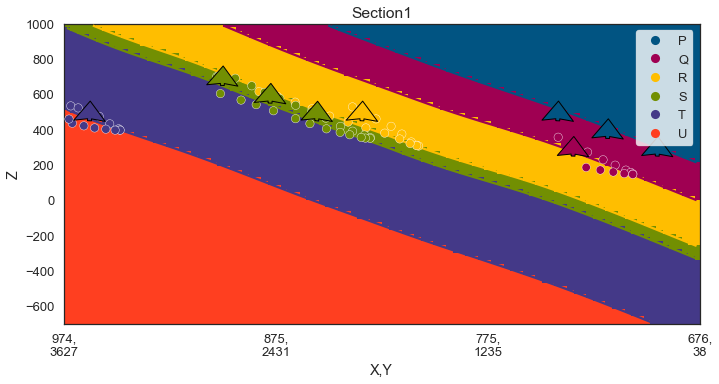

In [32]:
gp.plot_2d(geo_model, section_names=['Section1'])

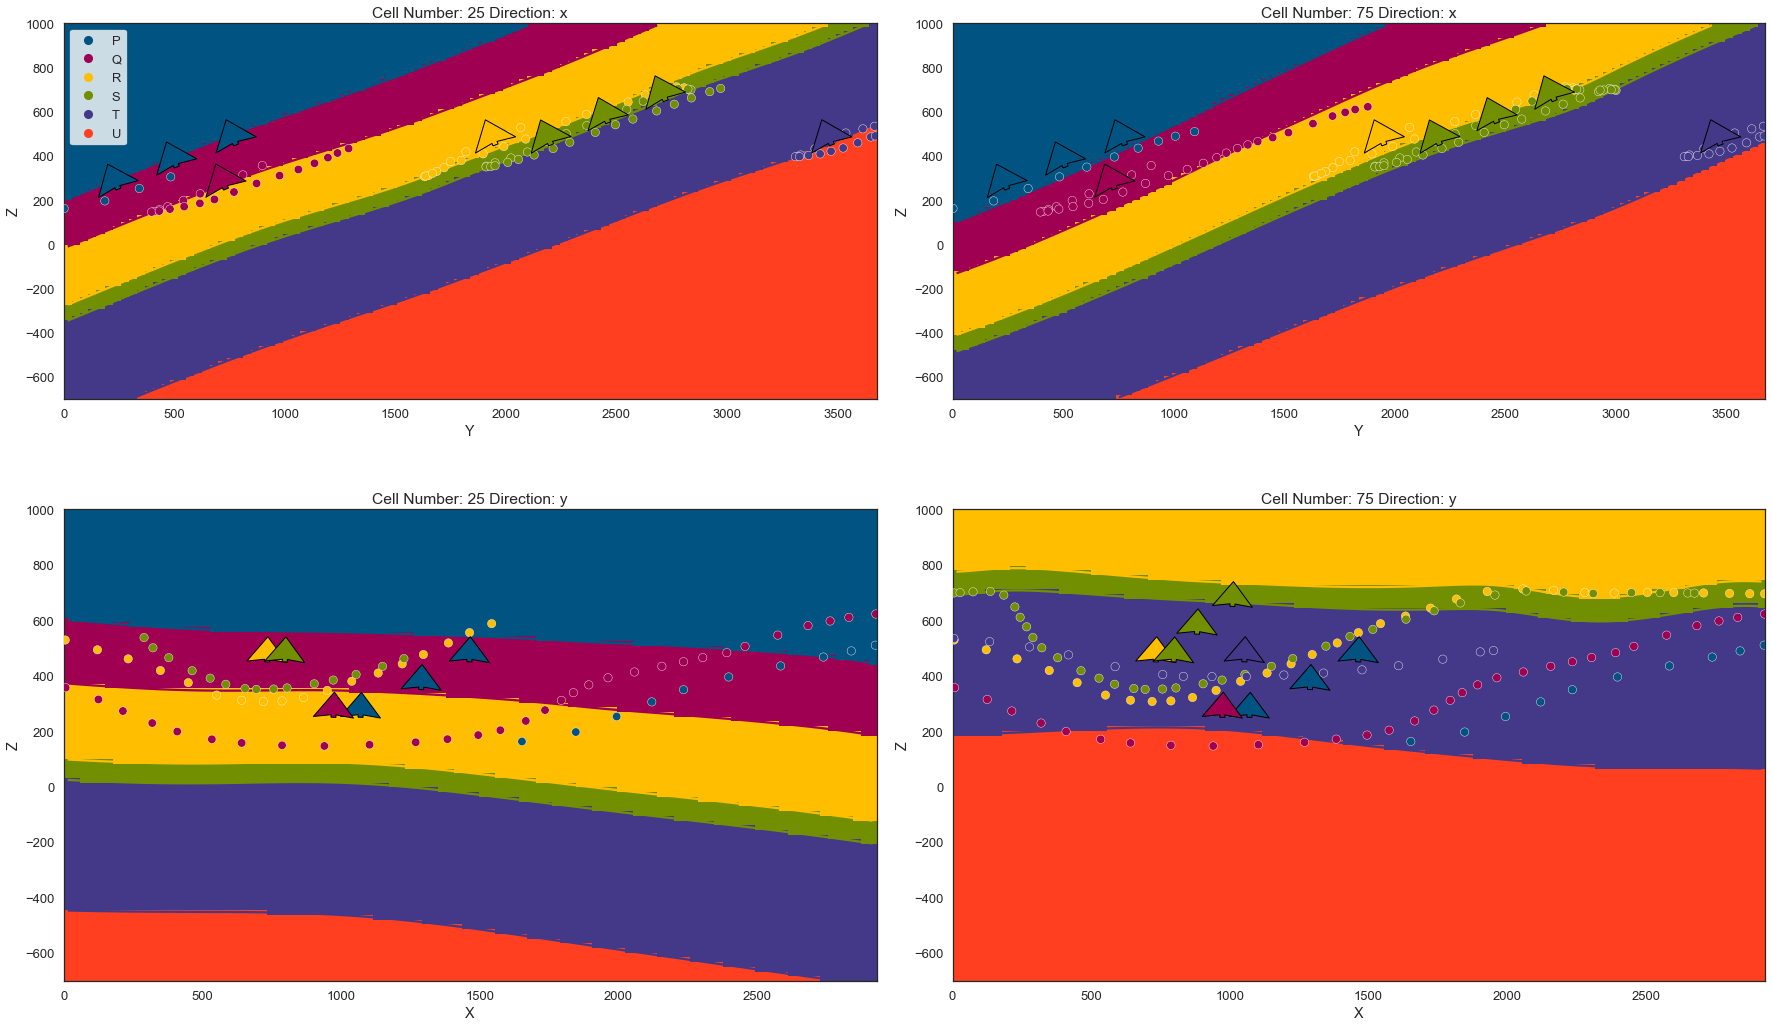

In [33]:
gp.plot_2d(geo_model, direction=['x', 'x', 'y', 'y'], cell_number=[25,75,25,75])

### Plotting 3D Model

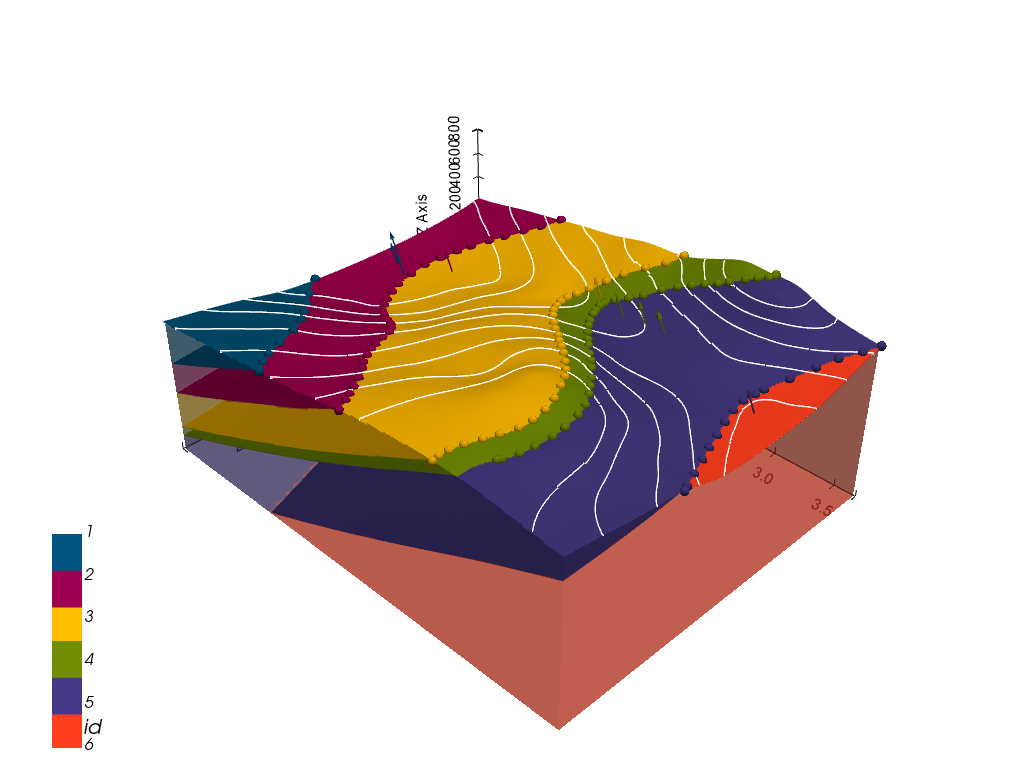

In [34]:
gpv = gp.plot_3d(geo_model, image=False, show_topography=True,
                 plotter_type='basic', notebook=True, show_lith=True)